In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fertility-rate-per-country/API_SP.DYN.TFRT.IN_DS2_en_csv_v2_5455118.csv


In [2]:
df = pd.read_csv('/kaggle/input/fertility-rate-per-country/API_SP.DYN.TFRT.IN_DS2_en_csv_v2_5455118.csv')

In [3]:
df.head()

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,4.820000,4.655000,4.471000,4.271000,4.059000,3.842000,3.625000,3.417000,...,2.117000,2.148000,1.972000,1.953000,1.839000,1.587000,1.486000,1.325000,1.180000,NaN
1,Africa Eastern and Southern,AFE,6.724125,6.742752,6.762930,6.778712,6.788420,6.800322,6.810571,6.818612,...,4.808821,4.739863,4.677619,4.615671,4.570410,4.527707,4.482899,4.416902,4.354710,NaN
2,Afghanistan,AFG,7.282000,7.284000,7.292000,7.302000,7.304000,7.305000,7.320000,7.339000,...,5.696000,5.560000,5.405000,5.262000,5.129000,5.002000,4.870000,4.750000,4.643000,NaN
3,Africa Western and Central,AFW,6.458448,6.471518,6.491826,6.506088,6.525355,6.541102,6.564967,6.589806,...,5.506350,5.437493,5.385059,5.328709,5.255345,5.186319,5.118932,5.049329,4.978662,NaN
4,Angola,AGO,6.708000,6.790000,6.872000,6.954000,7.036000,7.116000,7.194000,7.267000,...,5.953000,5.864000,5.774000,5.686000,5.600000,5.519000,5.442000,5.371000,5.304000,NaN


In [4]:
df.columns

Index(['Country Name', 'Country Code', '1960', '1961', '1962', '1963', '1964',
       '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020', '2021', '2022'],
      dtype='object')

In [5]:
df[df['Country Name'] == 'Brazil']

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
29,Brazil,BRA,6.061,6.044,5.995,5.929,5.818,5.675,5.529,5.368,...,1.748,1.767,1.777,1.709,1.736,1.749,1.703,1.649,1.641,NaN


# Curiosidade: taxa de fecundidade nos países do BRICS(menos Russia)

**Os dados do país não estavam disponíveis
**

In [6]:
brics = df[df['Country Name'].isin(['Brazil', 'China', 'India', 'South Africa'])].drop('Country Code', axis=1)

<Axes: >

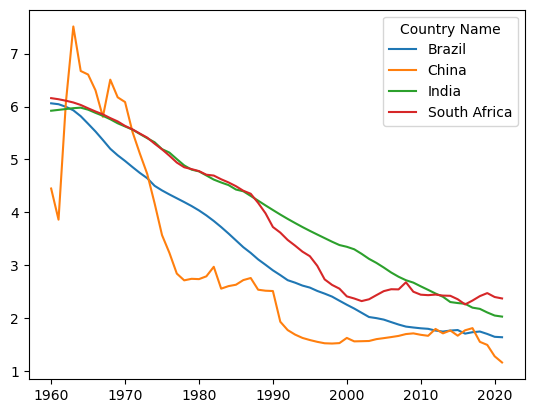

In [7]:
brics.set_index('Country Name').T.plot()

# Separando os dados

In [8]:
filtered_df = df.dropna(subset=['2021'])
X = filtered_df.drop(['Country Name', 'Country Code', '2021', '2022'], axis=1)
y = filtered_df['2021']

# Criando o Modelo

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer

In [10]:
imputer = SimpleImputer(strategy='constant')
random_forest_regressor = RandomForestRegressor()
pipeline_random_forest = Pipeline(steps=[
    ('imputer', imputer),
    ('model', random_forest_regressor)
])

# Avaliando o modelo com Cross-Validation

In [11]:
scores = -1 * cross_val_score(pipeline_random_forest, X, y, cv=5, scoring='neg_mean_absolute_error')

In [12]:
scores.mean()

0.0725536416429968

# Prevendo os valores de 2021

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [14]:
xgb_regressor = XGBRegressor(n_estimators=1000, early_stopping_rounds=5, learning_rate=0.05)
preprocessor = ColumnTransformer(transformers=[
    ('imputer', imputer, X_train.columns)
])
preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)
fit_params = {
    'model__eval_set': [(X_test_trans, y_test)],
    'model__verbose': False
}
pipeline_xgboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_regressor)

])

In [15]:
pipeline_xgboost.fit(X_train, y_train, **fit_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('imputer',
                                                  SimpleImputer(strategy='constant'),
                                                  Index(['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [16]:
predictions = pipeline_xgboost.predict(X_test)

In [17]:
mae = mean_absolute_error(y_test, predictions)
mean_test = y_test.mean()
mape = mae / mean_test * 100

In [18]:
mape

2.9341675642676655

In [19]:
y_df = pd.DataFrame(y_test).reset_index(drop=True)
pred_df = pd.DataFrame(predictions, columns=['2021'])
compare = pd.concat([y_df, pred_df], axis=1, ignore_index=True)

In [20]:
compare.columns = ['Actual', 'Prediction']

<Axes: >

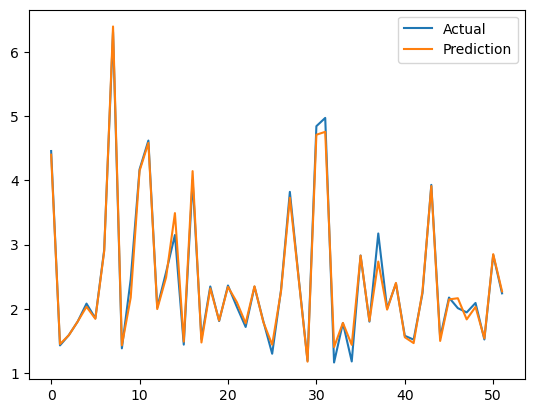

In [21]:
compare.plot()